In [16]:
from pycalphad import Database, Model, equilibrium, calculate
import pycalphad.variables as v
from tinydb import where
import sympy
from sympy import S, log, exp

import pycalphad.io.tdb_keywords
pycalphad.io.tdb_keywords.TDB_PARAM_TYPES.extend(['THETA', 'THETAX', 'THETAY','THETAZ'])

class EinsteinModel(Model):     
    def einstein_energy(self, dbe):
        phase = dbe.phases[self.phase_name]
        param_search = dbe.search
        theta_param_query = (
            (where('phase_name') == phase.name) & \
            (where('parameter_type') == 'THETA') & \
            (where('constituent_array').test(self._array_validity))
        )
        thetax_param_query = (
            (where('phase_name') == phase.name) & \
            (where('parameter_type') == 'THETAX') & \
            (where('constituent_array').test(self._array_validity))
        )
        thetay_param_query = (
            (where('phase_name') == phase.name) & \
            (where('parameter_type') == 'THETAY') & \
            (where('constituent_array').test(self._array_validity))
        )
        thetaz_param_query = (
            (where('phase_name') == phase.name) & \
            (where('parameter_type') == 'THETAZ') & \
            (where('constituent_array').test(self._array_validity))
        )
        lntheta = self.redlich_kister_sum(phase, param_search, theta_param_query)
        lnthetax = self.redlich_kister_sum(phase, param_search, thetax_param_query)
        lnthetay = self.redlich_kister_sum(phase, param_search, thetay_param_query)
        lnthetaz = self.redlich_kister_sum(phase, param_search, thetaz_param_query)
        theta = sympy.exp(lntheta)
        thetax = sympy.exp(lnthetax)
        thetay = sympy.exp(lnthetay)
        thetaz = sympy.exp(lnthetaz)
        self.lntheta = self.symbol_replace(lntheta, dbe.symbols)
        if lntheta != 0:
            result = 1.5*v.R*theta + 3*v.R*v.T*sympy.log(1-sympy.exp(-theta/v.T))
        else:
            result = 0
        if lnthetax != 0:
            resultx = 1.5*v.R*thetax + 3*v.R*v.T*sympy.log(1-sympy.exp(-thetax/v.T))
        else:
            resultx = 0
        if lnthetay != 0:
            resulty = 1.5*v.R*thetay + 3*v.R*v.T*sympy.log(1-sympy.exp(-thetay/v.T))
        else:
            resulty = 0
        if lnthetaz != 0:
            resultz = 1.5*v.R*thetaz + 3*v.R*v.T*sympy.log(1-sympy.exp(-thetaz/v.T))
        else:
            resultz = 0
        return (result + (resultx+resulty+resultz)/3) / self._site_ratio_normalization(phase)

    einstein_cpm = property(lambda self: -v.T*self.models['ein'].diff(v.T, v.T))
    magnetic_cpm = property(lambda self: -v.T*self.models['mag'].diff(v.T, v.T))
    excess_cpm = property(lambda self: -v.T*self.models['xsmix'].diff(v.T, v.T))
    ideal_cpm = property(lambda self: -v.T*self.models['idmix'].diff(v.T, v.T))
    ref_cpm = property(lambda self: -v.T*self.models['ref'].diff(v.T, v.T))
    einstein_gm = property(lambda self: self.models['ein'])
    magnetic_gm = property(lambda self: self.models['mag'])

In [17]:
from pycalphad import calculate
dbf = Database('FeMn.tdb')
res = calculate(dbf, ['MN', 'FE', 'VA'], 'FCC_A1', T=1000, P=101325, output='einstein_gm', model=EinsteinModel)
res2 = calculate(dbf, ['MN', 'FE', 'VA'], 'FCC_A1', T=1000, P=101325, output='GM', model=EinsteinModel)

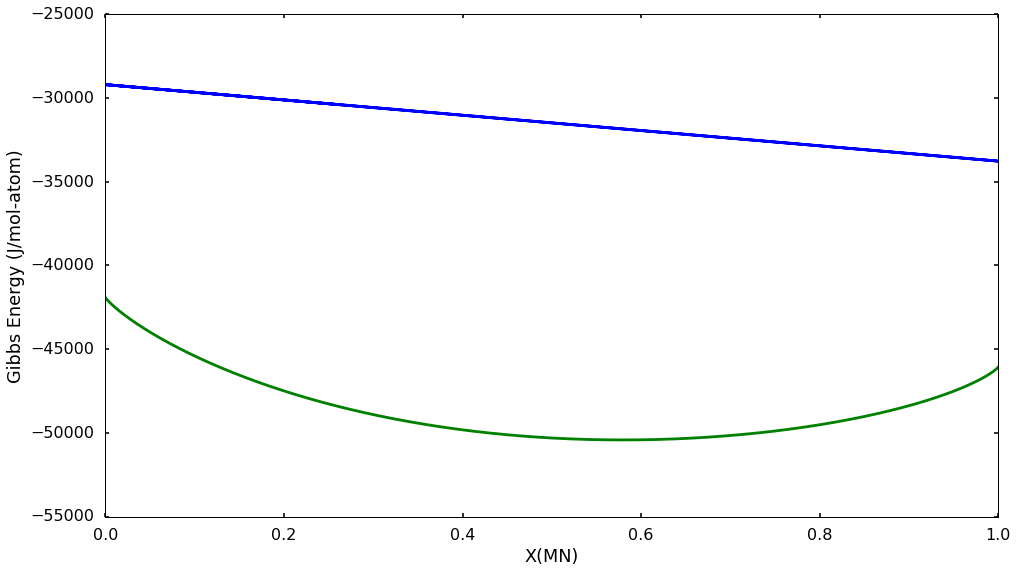

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
matplotlib.style.use('seaborn-poster')

fig = plt.figure(figsize=(16,9))
ax = fig.gca()

ax.plot(res['X'].sel(component='MN').values.flatten(), res['einstein_gm'].values.flatten())
comps_to_sort = res2['X'].sel(component='MN').values.flatten()
sort_indices = np.argsort(comps_to_sort)
ax.plot(comps_to_sort[sort_indices], res2['GM'].values.flatten()[sort_indices])
ax.set_xlabel('X(MN)')
ax.set_ylabel('Gibbs Energy (J/mol-atom)')

(5, 170)


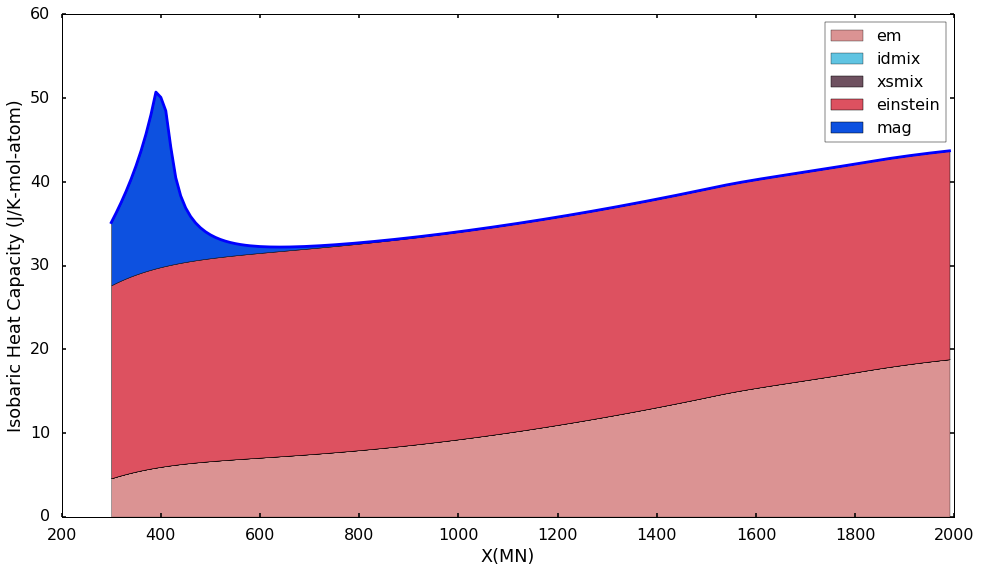

In [47]:
from pycalphad import equilibrium
import numpy as np
dbf = Database('FeMn.tdb')
eq = equilibrium(dbf, ['MN', 'FE', 'VA'], 'FCC_A1', {v.T: (300, 2000, 10), v.P: 101325, v.X('MN'): 0.3}, 
               output=['magnetic_cpm', 'excess_cpm', 'ideal_cpm', 'ref_cpm', 'einstein_cpm', 'CPM'],
                 model=EinsteinModel)

cpm_stack = np.cumsum([eq['ref_cpm'].values.flatten(),
                       eq['ideal_cpm'].values.flatten(),
                       eq['excess_cpm'].values.flatten(),
                       eq['einstein_cpm'].values.flatten(),
                       eq['magnetic_cpm'].values.flatten()
                      ], axis=0,)
print(cpm_stack.shape)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
matplotlib.style.use('seaborn-poster')

fig = plt.figure(figsize=(16,9))
ax = fig.gca()
temps = eq['T'].values.flatten()
ax.plot(temps, eq['CPM'].values.flatten())
ax.fill_between(temps, 0, cpm_stack[0,:], facecolor="#CC6666", alpha=.7, label='em')
ax.fill_between(temps, cpm_stack[0,:], cpm_stack[1,:], facecolor="#1DACD6", alpha=.7, label='idmix')
ax.fill_between(temps, cpm_stack[1,:], cpm_stack[2,:], facecolor="#6E5160", label='xsmix')
ax.fill_between(temps, cpm_stack[2,:], cpm_stack[3,:], facecolor="#DD5160", label='einstein')
ax.fill_between(temps, cpm_stack[3,:], cpm_stack[4,:], facecolor="#0D51E0", label='mag')
ax.set_xlabel('X(MN)')
ax.set_ylabel('Isobaric Heat Capacity (J/K-mol-atom)')
ax.legend()

In [20]:
res['CPM'].values.flatten()

array([ 28.20279809,  27.70576052,  27.70576052, ...,  45.8050299 ,
        46.03312884,  42.82403057])

In [22]:
res['T']

<xarray.DataArray 'T' (T: 17)>
array([  300.,   400.,   500.,   600.,   700.,   800.,   900.,  1000.,
        1100.,  1200.,  1300.,  1400.,  1500.,  1600.,  1700.,  1800.,
        1900.])
Coordinates:
  * T        (T) float64 300.0 400.0 500.0 600.0 700.0 800.0 900.0 1e+03 ...